In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import History, EarlyStopping
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM

In [2]:
CHANNEL = "D-12"

In [3]:
class Channel:
    def __init__(self, chan_id):
        self.id = chan_id
        self.train = None
        self.test = None
        self.l_s = 250
        self.n_predictions = 10
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.y_hat = None

    def shape_data(self, arr, training=True):
        data = []
        for i in range(len(arr) - self.l_s - self.n_predictions):
            data.append(arr[i: i + self.l_s + self.n_predictions])
            
        data = np.array(data)

        if training:
            np.random.shuffle(data)
            self.X_train = data[:, :-self.n_predictions, :]
            self.y_train = data[:, -self.n_predictions:, 0]
        else:
            self.X_test = data[:, :-self.n_predictions, :]
            self.y_test = data[:, -self.n_predictions:, 0]

    def load_data(self):
        try:
            self.train = np.load(os.path.join("data", "train", "{}.npy".format(self.id)))
            self.test = np.load(os.path.join("data", "test", "{}.npy".format(self.id)))
        except FileNotFoundError as e:
            print(e)

        self.shape_data(self.train)
        self.shape_data(self.test, training=False)

In [4]:
new_channel = Channel(CHANNEL)
new_channel.load_data()

In [5]:
new_channel.X_train.shape[2]

25

In [6]:
new_channel.test.shape

(7918, 25)

In [7]:
new_channel.test.shape
new_channel.X_test.shape
new_channel.X_test.shape

(7658, 250, 25)

In [8]:
new_channel.train

array([[-1.,  0.,  0., ...,  0.,  0.,  0.],
       [-1.,  0.,  0., ...,  0.,  0.,  0.],
       [-1.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [-1.,  0.,  0., ...,  0.,  0.,  0.],
       [-1.,  0.,  0., ...,  0.,  0.,  0.],
       [-1.,  0.,  0., ...,  0.,  0.,  0.]])

In [9]:
class Model:
    def __init__(self, channel):
        self.chan_id = channel.id
        self.y_hat = np.array([])
        self.model = None
        self.train_new(channel)
        

    def train_new(self, channel):
        cbs = [History(), EarlyStopping(monitor='val_loss',
                                        patience=10,
                                        min_delta=0.0003,
                                        verbose=0)]

        self.model = Sequential()

        self.model.add(LSTM(
            80,
            input_shape=(None, channel.X_train.shape[2]),
            return_sequences=True))
        self.model.add(Dropout(0.3))

        self.model.add(LSTM(
            80,
            return_sequences=False))
        self.model.add(Dropout(0.3))

        self.model.add(Dense(
            channel.n_predictions))
        self.model.add(Activation('linear'))

        self.model.compile(loss='mse',
                           optimizer='adam')

        self.model.fit(channel.X_train,
                       channel.y_train,
                       batch_size=64,
                       epochs=35,
                       validation_split=0.2,
                       callbacks=cbs,
                       verbose=True)
        
    def aggregate_predictions(self, y_hat_batch, method='first'):
        agg_y_hat_batch = np.array([])

        for t in range(len(y_hat_batch)):

            start_idx = t - 10
            start_idx = start_idx if start_idx >= 0 else 0

            # predictions pertaining to a specific timestep lie along diagonal
            y_hat_t = np.flipud(y_hat_batch[start_idx:t+1]).diagonal()

            if method == 'first':
                agg_y_hat_batch = np.append(agg_y_hat_batch, [y_hat_t[0]])
            elif method == 'mean':
                agg_y_hat_batch = np.append(agg_y_hat_batch, np.mean(y_hat_t))

        agg_y_hat_batch = agg_y_hat_batch.reshape(len(agg_y_hat_batch), 1)
        self.y_hat = np.append(self.y_hat, agg_y_hat_batch)
              
    def batch_predict(self, channel):
        num_batches = int((channel.y_test.shape[0] - 250)
                          / 70)

        for i in range(0, num_batches + 1):
            prior_idx = i * 70
            idx = (i + 1) * 70

            if i + 1 == num_batches + 1:
                idx = channel.y_test.shape[0]

            X_test_batch = channel.X_test[prior_idx:idx]
            y_hat_batch = self.model.predict(X_test_batch)
            self.aggregate_predictions(y_hat_batch)

        self.y_hat = np.reshape(self.y_hat, (self.y_hat.size,))

        channel.y_hat = self.y_hat

        return channel


In [10]:
model = Model(new_channel)

2024-03-16 11:34:06.076717: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-16 11:34:06.077027: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/35


2024-03-16 11:34:06.965709: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-03-16 11:34:08.911649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-16 11:34:09.371922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-16 11:34:12.307009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-16 11:34:15.343296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-16 11:34:53.865671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 0.9543

2024-03-16 11:35:31.448594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-16 11:35:31.611023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-16 11:35:34.520938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 90s 90s/step - loss: 0.9543 - val_loss: 0.8736
Epoch 2/35
1/1 [==============================] - 0s 345ms/step - loss: 0.8659 - val_loss: 0.7819
Epoch 3/35
1/1 [==============================] - 0s 327ms/step - loss: 0.7736 - val_loss: 0.6789
Epoch 4/35
1/1 [==============================] - 0s 325ms/step - loss: 0.6714 - val_loss: 0.5593
Epoch 5/35
1/1 [==============================] - 0s 326ms/step - loss: 0.5547 - val_loss: 0.4199
Epoch 6/35
1/1 [==============================] - 0s 326ms/step - loss: 0.4220 - val_loss: 0.2655
Epoch 7/35
1/1 [==============================] - 0s 328ms/step - loss: 0.2808 - val_loss: 0.1209
Epoch 8/35
1/1 [==============================] - 0s 326ms/step - loss: 0.1596 - val_loss: 0.0366
Epoch 9/35
1/1 [==============================] - 0s 325ms/step - loss: 0.1098 - val_loss: 0.0284
Epoch 10/35
1/1 [==============================] - 0s 323ms/step - loss: 0.1344 - val_loss: 0.0366
Epoch 11/35
1/1 [==============

In [11]:
model.batch_predict(new_channel)

2024-03-16 11:35:45.080560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-16 11:35:45.224641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-16 11:35:48.145023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [12]:
new_channel.y_hat.shape

(7658,)

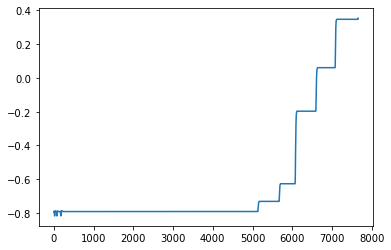

In [13]:
plt.plot(new_channel.y_hat)

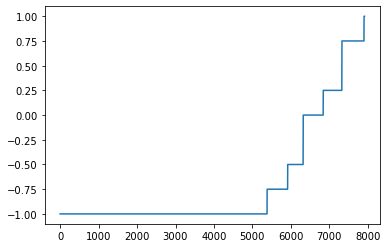

In [14]:
plt.plot(new_channel.test[:, 0])

In [15]:
class Plotter:
    def __init__(self, channel):
        self.channel = channel

    def plot_predictions(self, plot_real_data=True):
        if plot_real_data:
            plt.plot(self.channel.y_test[:, 0])
        else:
            plt.plot(self.channel.y_hat)

        anomalies = pd.read_csv("data/labeled_anomalies.csv")
        anomalies = anomalies[anomalies["chan_id"] == self.channel.id]
        anomalies_plot = anomalies['anomaly_sequences']
        anomalies_plot = eval(anomalies_plot.iloc[0])

        for rect in anomalies_plot:
            plt.axvspan(rect[0], rect[1], alpha=0.3, color='red')
        plt.show()
        
    
    def plot_custom_range_predictions(self, start, end, plot_real_data=True):
        if plot_real_data:
            plt.plot([i for i in range(start, end)], self.channel.y_test[:, 0][start:end])
        else:
             plt.plot([i for i in range(start, end)], self.channel.y_hat[start:end])

        anomalies = pd.read_csv("data/labeled_anomalies.csv")
        anomalies = anomalies[anomalies["chan_id"] == self.channel.id]
        anomalies_plot = anomalies['anomaly_sequences']
        anomalies_plot = eval(anomalies_plot.iloc[0])

        for rect in anomalies_plot:
            plt.axvspan(rect[0], rect[1], alpha=0.3, color='red')
        plt.show()
        
    def plot_threshold(self, error, threshold):
        plt.figure(figsize=(20,10))
        plt.plot(error)
        plt.plot([threshold for i in range(len(e_s))])

        anomalies = pd.read_csv("data/labeled_anomalies.csv")
        anomalies = anomalies[anomalies["chan_id"] == self.channel.id]
        anomalies_plot = anomalies['anomaly_sequences']
        anomalies_plot = eval(anomalies_plot.iloc[0])

        for rect in anomalies_plot:
            plt.axvspan(rect[0], rect[1], alpha=0.3, color='red')
        plt.show()

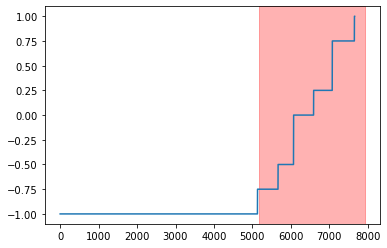

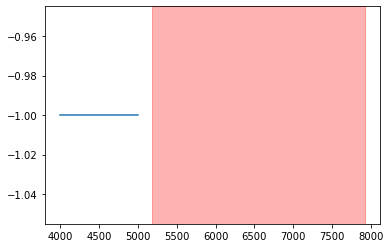

In [16]:
plotter = Plotter(new_channel)
plotter.plot_predictions()
plotter.plot_custom_range_predictions(4000, 5000)

In [17]:
error = np.abs(new_channel.y_test[:, 0] - new_channel.y_hat)
normalized = np.mean(error / np.ptp(new_channel.y_test))
normalized, error

(0.10286591433949223,
 array([0.2084865 , 0.2084437 , 0.20841837, ..., 0.65173459, 0.64959651,
        0.64638466]))

In [18]:
e_s = pd.DataFrame(error).ewm(span=105).mean().values.flatten()
e_s

array([0.2084865 , 0.2084649 , 0.20844909, ..., 0.41644483, 0.42084392,
       0.4250994 ])

In [19]:
import more_itertools as mit

def calculate_epsilon(e_s):
    epsilon = 0
    max_score = float('-inf')

    for i in np.arange(2, 10, 0.5):
        mean = np.mean(e_s)
        std = np.std(e_s)
        eps = mean + i*std

        delta_mean = mean - np.mean(e_s[e_s < eps])
        delta_std = std - np.std(e_s[e_s < eps])
        e_a = e_s[e_s >= eps]

        if len(e_a) > 0:
            anom = np.argwhere(e_s >= eps).reshape(-1)
            anom =[list(g) for g in mit.consecutive_groups(anom)]
            E_seq = len(anom)
            
            score = ((delta_mean/mean) + (delta_std/std)) / (E_seq**2 + len(e_a))
            if score > max_score:
                max_score = score
                epsilon = eps
    return epsilon

epsilon = calculate_epsilon(e_s)

In [20]:
# e_s = pd.DataFrame(error).ewm(span=105).mean().values.flatten()

# max_score = -10000000

# mean_e_s = np.mean(e_s)
# sd_e_s = np.std(e_s)
# EPSILON = 0

# for z in np.arange(2.5, 12, 0.5):
#     epsilon = mean_e_s + (sd_e_s * z)

#     pruned_e_s = e_s[e_s < epsilon]

#     i_anom = np.argwhere(e_s >= epsilon).reshape(-1,)
#     buffer = np.arange(1, 100)
#     i_anom = np.sort(np.concatenate((i_anom,
#                                     np.array([i+buffer for i in i_anom])
#                                         .flatten(),
#                                     np.array([i-buffer for i in i_anom])
#                                         .flatten())))
#     i_anom = i_anom[(i_anom < len(e_s)) & (i_anom >= 0)]
#     i_anom = np.sort(np.unique(i_anom))

#     if len(i_anom) > 0:
#         # group anomalous indices into continuous sequences
#         groups = [list(group) for group
#                     in mit.consecutive_groups(i_anom)]
#         E_seq = [(g[0], g[-1]) for g in groups if not g[0] == g[-1]]

#         mean_perc_decrease = (mean_e_s - np.mean(pruned_e_s)) / mean_e_s
#         sd_perc_decrease = (sd_e_s - np.std(pruned_e_s)) \
#                                    / sd_e_s
#         score = (mean_perc_decrease + sd_perc_decrease) \
#                 / (len(E_seq) ** 2 + len(i_anom))

#         # sanity checks / guardrails
#         if score >= max_score and len(E_seq) <= 5 and \
#                 len(i_anom) < (len(e_s) * 0.5):
#             max_score = score

#             sd_threshold = z
#             EPSILON = mean_e_s + z * sd_e_s
# epsilon = EPSILON

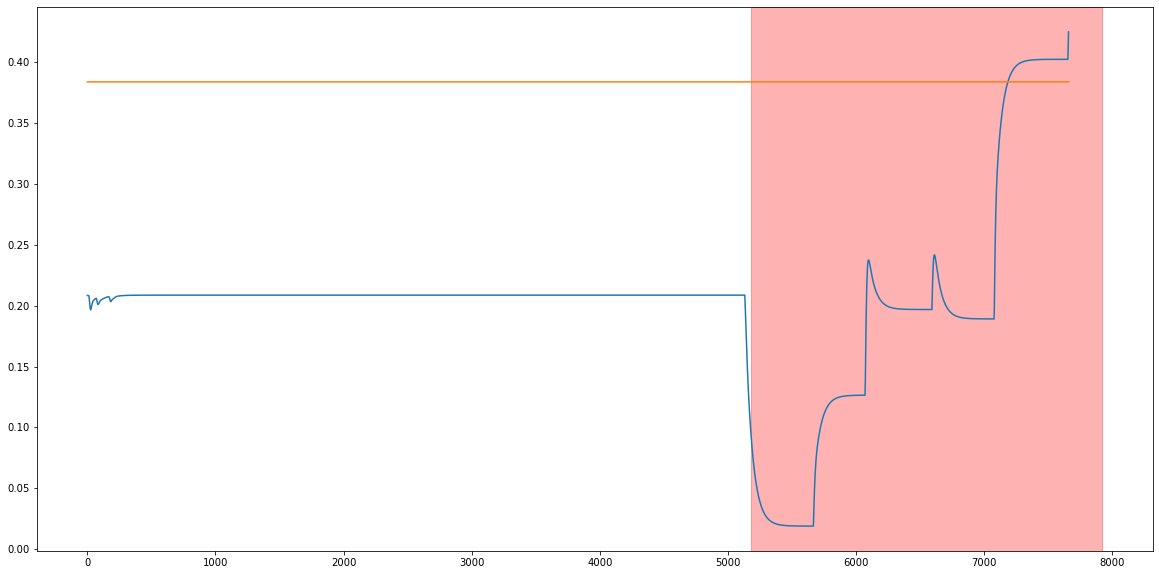

In [21]:
plotter.plot_threshold(e_s, epsilon)

In [22]:
class Errors:
    def __init__(self, channel):
        self.channel = channel
        self.error = np.abs(channel.y_test[:, 0] - channel.y_hat)
        self.normalized = np.mean(self.error / np.ptp(channel.y_test))
        self.e_s = pd.DataFrame(self.error).ewm(span=105).mean().values.flatten()

    def calculate_epsilon(self):
        epsilon = 0
        max_score = float('-inf')

        for i in np.arange(2, 10, 0.5):
            mean = np.mean(self.e_s)
            std = np.std(self.e_s)
            eps = mean + i*std
            e_s = self.e_s

            delta_mean = mean - np.mean(e_s[e_s < eps])
            delta_std = std - np.std(e_s[e_s < eps])
            e_a = e_s[e_s >= eps]

            if len(e_a) > 0:
                anom = np.argwhere(e_s >= eps).reshape(-1)
                anom =[list(g) for g in mit.consecutive_groups(anom)]
                E_seq = len(anom)
                
                score = ((delta_mean/mean) + (delta_std/std)) / (E_seq**2 + len(e_a))
                if score > max_score:
                    max_score = score
                    epsilon = eps
        return epsilon

In [23]:
errors = Errors(new_channel)
epsilon = errors.calculate_epsilon()
epsilon

0.38401276009148455

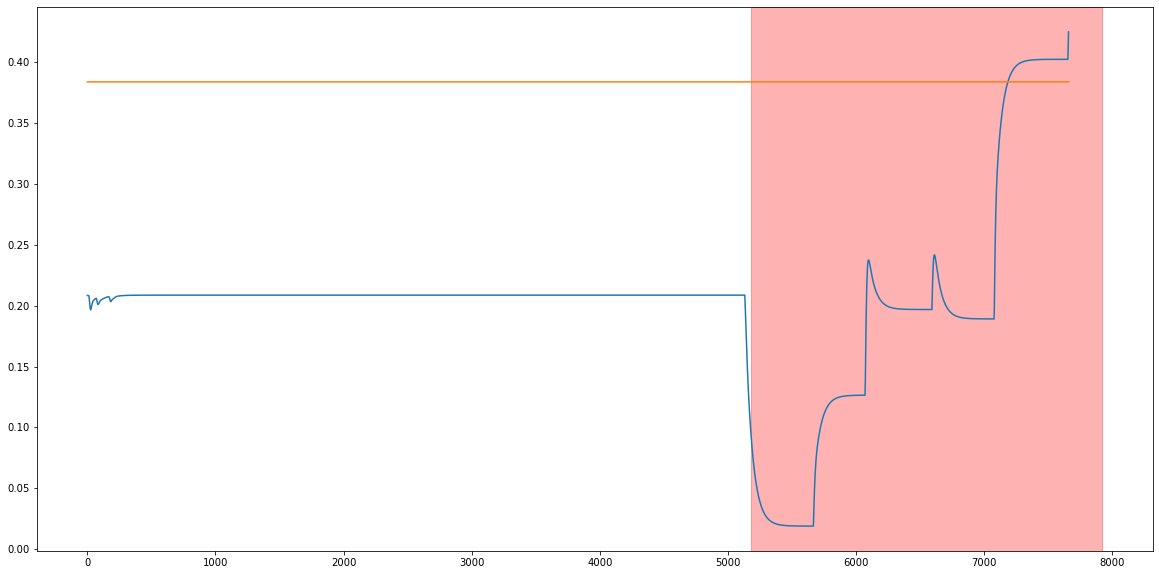

In [24]:
plotter.plot_threshold(errors.e_s, epsilon)